In [1]:
import pandas as pd
import numpy as np
import os
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import soundfile as sf

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
seed(1)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

import pickle

pd.set_option('display.max_rows', 200)
path = 'wav_data'
sr = 8000
n_fft = 2048
n_mels = 128
fmax = 4000

In [2]:
# создаём список файлов с женскими голосами
female = list(pd.read_csv('f.txt', header=None)[0])
# создаём список файлов с мужскими голосами
male = list(pd.read_csv('m.txt', header=None)[0])

In [3]:
# создаём датафрейм, записываем в него имя файла и пол
df = pd.concat([pd.DataFrame([[x,'f'] for x in female], columns=['Record_name','Gender']),
                             pd.DataFrame([[x,'m'] for x in male], columns=['Record_name','Gender'])], ignore_index=True)
df

,Record_name,Gender
0,A30000A1.wav,f
1,A30000A1.wav2,f
2,A30000A2.wav,f
3,A30000A3.wav,f
4,A30000A4.wav,f
...,...,...
200,A30003X2.wav,m
201,A30003X3.wav,m
202,A30003X4.wav,m
203,A30003X5.wav,m


In [4]:
# создаём столбцы под обогащение данных
df['Spectral_centroid'] = np.nan
df['Rolloff'] = np.nan
df['Bandwidth'] = np.nan
#df['Zero_crossing'] = np.nan
df['Max_mean_freq_1'] = np.nan
df['Max_mean_freq_2'] = np.nan
df['Max_mean_freq_3'] = np.nan
df['Max_mean_freq_all_1'] = np.nan
df['Max_mean_freq_all_2'] = np.nan
df['Max_mean_freq_all_3'] = np.nan
df['Freq_min_all'] = np.nan
df['Freq_min'] = np.nan

In [5]:
# определим функцию, вырезающую фрагмент с голосом (начало и конец определяются условием амплитуды выше средней по файлу)
def get_position (x, sr, coeff=5):
    z = np.array([np.abs(i) for i in x])
    k = 0
    l = len(z) - 1
    while z[k] < coeff * z.mean():
        k += 1
    while (z[l] < 7 * coeff * z.mean()) and (l > k + 1000):
        l -= 1
    bottom = round(k/sr,2)
    top = round(l/sr,2)
    return bottom, top

def get_position_alt (x, sr, coeff=5, dur = 0.5):
    z = np.array([np.abs(i) for i in x])
    k = 0
    while z[k] < coeff * z.mean():
        k += 1
    bottom = round(k/sr,2)
    top = bottom + dur
    return bottom, top

In [6]:
# создаём список с массивами преобразованных звуковых фрагментов
# loaded_data = []
# создаём список со спектрограммами
# spectrum = []
for i in range(len(df)):
#    print(i)
    # выкачиваем и преобразуем звуковые фрагменты
    x, sr_out = librosa.load(path+'\\'+str(df.loc[i,'Record_name']), sr=sr, mono=True)
    
    S, phase = librosa.magphase(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=n_mels, fmax=fmax))
    # средний спектр по записи
    D = S.mean(axis=1)
    D[0] = 0
#    plt.plot([x*8000/128 for x in range(len(D))], D)
    d = list(D)
    
    # добавляем частоту с максимальным средним в спектре 1
    df.loc[i,'Max_mean_freq_all_1'] = d.index(D.max()) * sr / n_mels
    
    D[d.index(D.max())] = 0
    D[d.index(D.max())-1] = 0
    if d.index(D.max()) < n_mels:
        D[d.index(D.max())+1] = 0
    d = list(D)
    # добавляем частоту с максимальным средним в спектре 2
    df.loc[i,'Max_mean_freq_all_2'] = d.index(D.max()) * sr / n_mels
    
    D[d.index(D.max())] = 0
    D[d.index(D.max())-1] = 0
    if d.index(D.max()) < n_mels:
        D[d.index(D.max())+1] = 0
    d = list(D)
    # добавляем частоту с максимальным средним в спектре 3
    df.loc[i,'Max_mean_freq_all_3'] = d.index(D.max()) * sr / n_mels
    # средний спектр по записи
    D = S.mean(axis=1)
    D[0] = 0
    d = list(D)
    ind = 0
    while D[ind] < D.mean():
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше среднего
    df.loc[i,'Freq_min_all'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 1.5:
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше 1.5 среднего
    df.loc[i,'Freq_min_all_1'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 2:
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше 2 средних
    df.loc[i,'Freq_min_all_2'] = ind * sr / n_mels
    
    ind = len(D) - 1
    
    while D[ind] < D.mean():
        ind -= 1
    # добавдяем максимальную частоту, где проявляется значение выше среднего
    df.loc[i,'Freq_max_all'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 1.5:
        ind -= 1
    # добавдяем максимальную частоту, где проявляется значение выше 1.5 среднего
    df.loc[i,'Freq_max_all_1'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 2:
        ind -= 1
    # добавдяем максимальную частоту, где проявляется значение выше 2 средних
    df.loc[i,'Freq_max_all_2'] = ind * sr / n_mels
    
    # делаем тоже самое для отрезка с голосом
    bottom, top = get_position(x, sr, coeff=5)
#    bottom, top = get_position_alt(x, sr, coeff=5, dur=0.25)
    x, sr_out = librosa.load(path+'\\'+str(df.loc[i,'Record_name']), sr=sr, mono=True,
                        offset=bottom, duration=top-bottom)
#    loaded_data.append(x)
    # получаем спектрограммы звуковых фрагментов и усредняем их по фреймам
#    D = np.abs(librosa.stft(x, n_fft=n_fft))
    # усредняем
#    D = D.mean(axis=1)
    # нормируем
#    s = D.sum()
#    D = D / s
#    spectrum.append(D)
    S, phase = librosa.magphase(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=n_mels, fmax=fmax))
    D = S.mean(axis=1)
    D[0] = 0
#    plt.plot([x*8000/128 for x in range(len(D))], D)
    d = list(D)
    
    # добавляем частоту с максимальным средним в спектре 1
    df.loc[i,'Max_mean_freq_1'] = d.index(D.max()) * sr / n_mels
    
    D[d.index(D.max())] = 0
    D[d.index(D.max())-1] = 0
    if d.index(D.max()) < n_mels:
        D[d.index(D.max())+1] = 0
    d = list(D)
    # добавляем частоту с максимальным средним в спектре 2
    df.loc[i,'Max_mean_freq_2'] = d.index(D.max()) * sr / n_mels
    
    D[d.index(D.max())] = 0
    D[d.index(D.max())-1] = 0
    if d.index(D.max()) < n_mels:
        D[d.index(D.max())+1] = 0
    d = list(D)
    # добавляем частоту с максимальным средним в спектре 3
    df.loc[i,'Max_mean_freq_3'] = d.index(D.max()) * sr / n_mels
    
    D = S.mean(axis=1)
    D[0] = 0
    d = list(D)
    ind = 0
    while D[ind] < D.mean():
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше среднего
    df.loc[i,'Freq_min'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 1.5:
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше 1.5 среднего
    df.loc[i,'Freq_min_1'] = ind * sr / n_mels
    
    while D[ind] < D.mean() * 2:
        ind += 1
    # добавдяем минимальную частоту, где проявляется значение выше 2 средних
    df.loc[i,'Freq_min_2'] = ind * sr / n_mels
    
    
    ind = len(D) - 1
    
    while D[ind] < D.mean():
        ind -= 1
    # добавдяем максимальную частоту, где проявляется значение выше среднего
    df.loc[i,'Freq_max'] = ind * sr / n_mels
    
       
    # добавляем усреднённый спектральный центроид
    df.loc[i,'Spectral_centroid'] = librosa.feature.spectral_centroid(S=S)[0].mean()
    # добавляем усреднённую спектральную ширину
    df.loc[i,'Bandwidth'] = librosa.feature.spectral_bandwidth(S=S)[0].mean()
    # спектральный спад
    df.loc[i,'Rolloff'] = librosa.feature.spectral_rolloff(S=S, sr=sr)[0].mean()
    # Скорость пересечения нуля
#    df.loc[i,'Zero_crossing'] = librosa.feature.zero_crossing_rate(x)[0].mean()

In [7]:
list(df)

['Record_name',
 'Gender',
 'Spectral_centroid',
 'Rolloff',
 'Bandwidth',
 'Max_mean_freq_1',
 'Max_mean_freq_2',
 'Max_mean_freq_3',
 'Max_mean_freq_all_1',
 'Max_mean_freq_all_2',
 'Max_mean_freq_all_3',
 'Freq_min_all',
 'Freq_min',
 'Freq_min_all_1',
 'Freq_min_all_2',
 'Freq_max_all',
 'Freq_max_all_1',
 'Freq_max_all_2',
 'Freq_min_1',
 'Freq_min_2',
 'Freq_max']

D:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



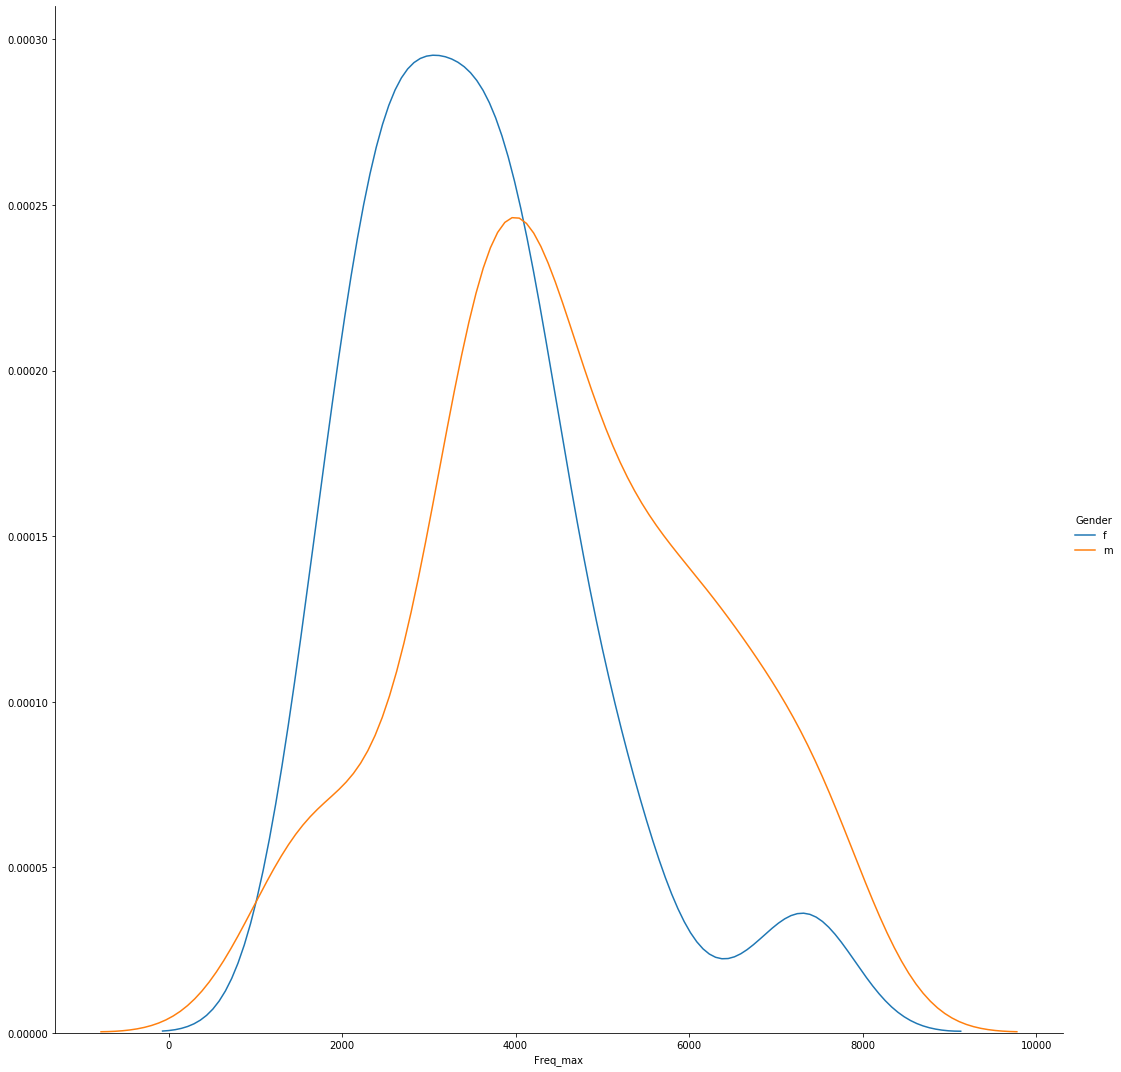

In [8]:
# Смотрим, KDE каких параметров отличается для женской и мужской выборки
sns.FacetGrid(df,hue='Gender',size=15).map(sns.kdeplot, 'Freq_max').add_legend()

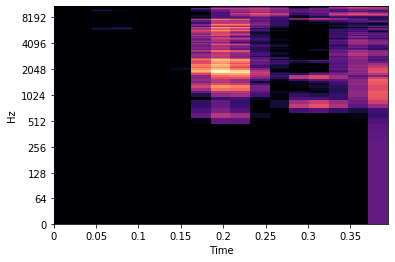

In [9]:
# визуализация спектра звуковых отрезков
x, sr_out = librosa.load(path+'\\'+str(df.loc[157,'Record_name']), sr=sr, mono=True)
bottom, top = get_position(x, sr, coeff=5)
x, sr_out = librosa.load(path+'\\'+str(df.loc[i,'Record_name']), sr=sr, mono=True,
                        offset=bottom, duration=top-bottom)
S, phase = librosa.magphase(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=n_mels, fmax=fmax))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')

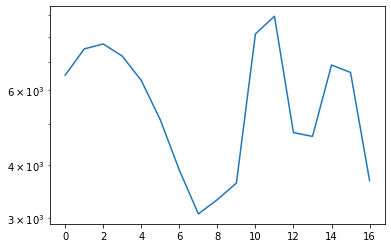

In [10]:
# спектральный центроид
plt.semilogy(librosa.feature.spectral_centroid(S=S)[0])

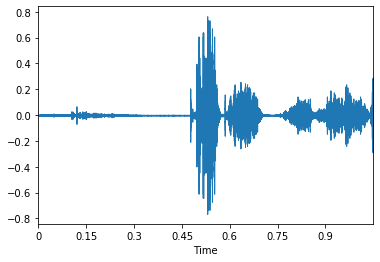

In [11]:
# графическая амплитудная визуализация запсиси
librosa.display.waveplot(x, sr=sr)

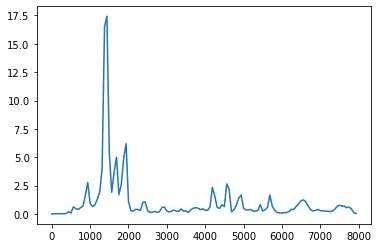

In [12]:
# усреднённая АЧХ
D = S.mean(axis=1)
D[0] = 0
plt.plot([x*8000/128 for x in range(len(D))], D)

In [13]:
d = list(D)
d.index(D.max()) * 8000 / 128

1437.5

In [14]:
# выкидываем неоправдавшие себя свойства
X, y = df[:].drop(['Gender', 'Record_name', 'Max_mean_freq_2', 'Max_mean_freq_3', 'Max_mean_freq_all_2',
               'Max_mean_freq_all_3','Freq_max_all', 'Freq_max_all_1', ],1), df['Gender']

In [15]:
y

0      f
1      f
2      f
3      f
4      f
      ..
200    m
201    m
202    m
203    m
204    m
Name: Gender, Length: 205, dtype: object

In [16]:
# нормализуем
scale_features_std = StandardScaler() 
X = scale_features_std.fit_transform(X) 

# засовываем параметры нормализации в пикл
B  = open('scaler.pkl', 'wb')
pickle.dump((scale_features_std.scale_, scale_features_std.mean_, scale_features_std.n_samples_seen_,
            scale_features_std.var_), B)
B.close()

In [17]:
# разбиваем выборку на тестовую и обучающую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0) 

In [18]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [19]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# процент правильных распознаваний на тестовой выборке
clf.score(X_test, y_test)

0.9024390243902439

In [21]:
# коэффициенты регрессии
clf.coef_[0]

array([-1.30707148, -0.31197054,  2.08557339, -0.30484503, -0.93272638,
        0.85076634,  0.10371833,  0.83417056,  2.23512895,  0.05498558,
        0.19435671,  0.55515185,  0.11795745])

In [22]:
clf.predict(X_test)

array(['f', 'm', 'f', 'f', 'm', 'm', 'f', 'm', 'm', 'f', 'f', 'm', 'f',
       'f', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'f', 'f', 'm', 'm', 'm',
       'm', 'm', 'm', 'f', 'm', 'm', 'f', 'm', 'f', 'f', 'm', 'm', 'f',
       'f', 'f'], dtype=object)

In [23]:
clf.predict_proba(X_test)

array([[9.67666777e-01, 3.23332225e-02],
       [1.14894227e-03, 9.98851058e-01],
       [6.69933114e-01, 3.30066886e-01],
       [8.09335623e-01, 1.90664377e-01],
       [9.31475672e-03, 9.90685243e-01],
       [1.14579218e-02, 9.88542078e-01],
       [9.95172271e-01, 4.82772885e-03],
       [1.13679652e-02, 9.88632035e-01],
       [2.80675001e-01, 7.19324999e-01],
       [9.66576246e-01, 3.34237539e-02],
       [9.85558343e-01, 1.44416571e-02],
       [2.54552790e-01, 7.45447210e-01],
       [9.78239029e-01, 2.17609711e-02],
       [9.17624459e-01, 8.23755414e-02],
       [5.04273646e-01, 4.95726354e-01],
       [8.05664761e-04, 9.99194335e-01],
       [1.97096094e-01, 8.02903906e-01],
       [8.82545811e-01, 1.17454189e-01],
       [7.91779442e-01, 2.08220558e-01],
       [2.24100144e-01, 7.75899856e-01],
       [7.05989144e-02, 9.29401086e-01],
       [5.84303049e-01, 4.15696951e-01],
       [6.98722186e-01, 3.01277814e-01],
       [1.42730920e-02, 9.85726908e-01],
       [1.129504

In [24]:
# теперь в качестве фита используем весь массив данных, выгрузим его для использования в классиыикаторе (другой файл)
clf = LogisticRegression(random_state=0).fit(X[:-1], y[:-1])
clf.coef_[0]

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([-1.37118535, -0.43201168,  2.36734354, -0.27724158, -0.95612435,
        0.93770992,  0.126717  ,  1.09394774,  1.53532909, -0.04485818,
        0.31961376,  0.49842645,  0.18105384])

In [25]:
clf.predict([X[-1]])

array(['m'], dtype=object)

In [26]:
print('belonging to ', clf.predict([X[-1]])[0], ' ', round(max(clf.predict_proba(X)[-1]) * 100,1), '%')

belonging to  m   97.8 %


In [27]:
# clf = LogisticRegression(random_state=0).fit(X, y)

In [28]:

A  = open('coeffs.pkl', 'wb')
pickle.dump((clf.coef_, clf.intercept_, clf.classes_), A)
A.close()